In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import open3d as o3d
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pickle

import matplotlib.pyplot as plt
import gtsam
import scipy
import tqdm
import gtsam.utils.plot as gtsam_plot
import math
import itertools

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
directory = './buddha_images/'
%matplotlib inline
img_names = os.listdir(directory)
img_names.sort()
print(img_names)
images_list = []
grey_images_list = []
for i in img_names:
    if i[-4:] == ".png":
        image = cv2.cvtColor(cv2.imread(directory+str(i)), cv2.COLOR_BGR2RGB)
        images_list.append(image)
        # plt.imshow(image)
        # break
        grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        grey_images_list.append(grey_image)
        print(grey_image.shape)

print(len(images_list))

['buddha_001.png', 'buddha_002.png', 'buddha_003.png', 'buddha_004.png', 'buddha_005.png', 'buddha_006.png', 'buddha_007.png', 'buddha_008.png', 'buddha_009.png', 'buddha_010.png', 'buddha_011.png', 'buddha_012.png', 'buddha_013.png', 'buddha_014.png', 'buddha_015.png', 'buddha_016.png', 'buddha_017.png', 'buddha_018.png', 'buddha_019.png', 'buddha_020.png', 'buddha_021.png', 'buddha_022.png', 'buddha_023.png', 'buddha_024.png']
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
24


In [4]:
'''Data Structures to use'''
class Point3D(object):
    def __init__(self, coords, origin):
        self.coords = coords
        self.origin = origin

class PointCloud(object):
    def __init__(self, points_3D, index, q1, q2):
        self.cloud = []
        self.create_pointcloud(points_3D, index, q1, q2)
    
    def find_3d_point(self, point, index):
        for old_point in self.cloud:
            try:
                if np.array_equal(point.origin[index], old_point.origin[index]):
                    return True, old_point
            except KeyError:
                continue
            
        return False, None
    
    def update(self, index, points_3D, q1, q2):
        count = 0
        for i, point_value in enumerate(points_3D):
            point = Point3D(point_value, {index: q1[i], index+1: q2[i]})
            success, old_point = self.find_3d_point(point, index)
            
            if success:
                old_point.origin[index+1] = q2[i]
            else:
                self.cloud.append(point)
        
    def scan_pointcloud(self, index, prev_keypoints, q1):
        matched_2d = []
        matched_3d = []
        matched_indices = []
        
        for i, point in enumerate(q1):
            for old_point in prev_keypoints:
                if np.array_equal(point, old_point):
                    matched_2d.append(point)
                    matched_indices.append(i)
        
        for i, point in enumerate(matched_2d):
            for point_3d in self.cloud:
                try:
                    if np.array_equal(point, point_3d.origin[index]):
                        matched_3d.append(point_3d.coords)
                        break
                except KeyError:
                    continue   
                
        matched_2d = np.array(matched_2d, dtype=np.float32)
        matched_3d = np.array(matched_3d, dtype=np.float32)
        
        if matched_2d.shape[0] != matched_3d.shape[0]:
            print("Error in matching")
            print("Matched 2d and 3d points: ", matched_2d.shape, matched_3d.shape)
            print("Prev keypoints: ", prev_keypoints.shape)
            print("q1: ", q1.shape)
            print("Index: ", index)            
            exit()
            
        return matched_2d, matched_3d, matched_indices
    
    def create_pointcloud(self, points_3D, index, q1, q2):
        for i, point in enumerate(points_3D):
            self.cloud.append(Point3D(point, {index: q1[i], index+1: q2[i]}))
            
    def get_pointcloud(self):
        points = []
        for point in self.cloud:
            points.append(point.coords)
            
        return np.array(points)

def make_pcd(points):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    return pcd

def plot_pointcloud(cloud:np.ndarray, cloud_color:np.ndarray):
    mask = np.linalg.norm(cloud, axis=1) < 1000
    cloud = cloud[mask]
    cloud_color = cloud_color[mask]
    plt.scatter(cloud[:,0], cloud[:,1], s=5, c=cloud_color/255.0, marker='o', label='Pointcloud')
    plt.show()    
    
def plot_camera_poses(camera_poses:dict):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    poses = []
    for key in camera_poses.keys():
        camera_pose = camera_poses[key]
        poses.append(np.array(camera_pose[0:3,3]))
        
    poses = np.array(poses)
    print(poses.shape)
    ax.scatter(poses[:,0], poses[:,1], poses[:,2], 'ro')
    
    plt.show()

def plot_camera_poses_with_pointcloud(camera_poses:dict, cloud:np.ndarray, cloud_color:np.ndarray, plot_camera=True, plot_cloud=True, remove_far_points=True):
    poses = []
    for key in camera_poses.keys():
        camera_pose = camera_poses[key]
        poses.append(np.array(camera_pose))
        
    poses = np.array(poses)
    
    # Extract camera positions and orientations
    positions = [pose[:3, 3] for pose in poses]
    orientations = [pose[:3, :3] for pose in poses]

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot camera positions
    for i in range(len(positions)):
        ax.scatter(positions[i][0], positions[i][1], positions[i][2], c='r', marker='o', label='Camera Poses')
        point = positions[i]
        ax.text(point[0], point[1], point[2],  '%s' % (str(i)), size=20, zorder=1,color='k') 

    # Plot camera orientations (axes)
    for i in range(len(orientations)):
        axis_len = 5  # Length of the camera coordinate axes
        x_axis = orientations[i].dot(np.array([axis_len, 0, 0]))
        y_axis = orientations[i].dot(np.array([0, axis_len, 0]))
        z_axis = orientations[i].dot(np.array([0, 0, axis_len]))
        ax.quiver(positions[i][0], positions[i][1], positions[i][2], x_axis[0], x_axis[1], x_axis[2], color='r', label='X-axis')
        ax.quiver(positions[i][0], positions[i][1], positions[i][2], y_axis[0], y_axis[1], y_axis[2], color='g', label='Y-axis')
        ax.quiver(positions[i][0], positions[i][1], positions[i][2], z_axis[0], z_axis[1], z_axis[2], color='b', label='Z-axis')

    # Plot pointcloud      
    if remove_far_points:
        mask = np.linalg.norm(cloud, axis=1) < 1000
        cloud = cloud[mask]
        cloud_color = cloud_color[mask]
        
    if plot_cloud:
        ax.scatter(cloud[:,0], cloud[:,1], cloud[:,2], s=5, c=cloud_color/255.0, marker='o', label='Pointcloud')

    # Set axis limits
    # ax.set_xlim3d(-40, 80)
    # ax.set_ylim3d(-30, 20)
    # ax.set_zlim3d(-10, 40)
    
    # Set axis labels
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    
    # Show the 3D plot
    plt.show()

def non_maximum_suppression(points):
    height, width = 1920,1080
    binary_mask = np.zeros((height, width), dtype=np.uint8)
    responses = np.array([point.response for point in points])
    mask = np.flip(np.argsort(responses))
    
    point_list = np.rint([point.pt for point in points])[mask].astype(int)
    
    nms_mask = []
    for point, index in zip(point_list, mask):
        if binary_mask[point[1], point[0]] == 0:
            nms_mask.append(index)
            cv2.circle(binary_mask, tuple(point), 2, 255, -1)
            
    return nms_mask

def compute_keypoints_list(images_list):

    keypoints_list = []
    desc_list = []
    try:
        sift = cv2.xfeatures2d.SIFT_create(5000, nOctaveLayers=3, contrastThreshold=0.04)
    except:
        sift = cv2.SIFT_create(5000, nOctaveLayers=3, contrastThreshold=0.04)

    for image in images_list:
        image_gray = image# cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # print(image_gray.shape)
        kp, desc = sift.detectAndCompute(image_gray, None)
        nms_mask = non_maximum_suppression(kp)
        kp = np.array(kp)[nms_mask]
        desc = np.array(desc)[nms_mask]
        print(kp.shape, desc.shape)
        keypoints_list.append(kp)
        desc_list.append(desc)

    return keypoints_list, desc_list

height, width = images_list[0].shape[:2]
K = np.array([[1500, 0, width/2], [0, 1500, height/2], [0, 0, 1]], dtype=np.float32)

keypoints_list, desc_list = compute_keypoints_list(grey_images_list)
print("LENGTH of keypoints and descriptors should be same")
print(len(keypoints_list),len(desc_list))
print("Number of Keypoints and dim[0] of descriptors should be same")
print(len(keypoints_list[0]), desc_list[0].shape)

(964,) (964, 128)
(491,) (491, 128)
(746,) (746, 128)
(688,) (688, 128)
(437,) (437, 128)
(521,) (521, 128)
(588,) (588, 128)
(669,) (669, 128)
(513,) (513, 128)
(387,) (387, 128)
(411,) (411, 128)
(666,) (666, 128)
(466,) (466, 128)
(379,) (379, 128)
(762,) (762, 128)
(659,) (659, 128)
(637,) (637, 128)
(526,) (526, 128)
(588,) (588, 128)
(781,) (781, 128)
(693,) (693, 128)
(702,) (702, 128)
(311,) (311, 128)
(494,) (494, 128)
LENGTH of keypoints and descriptors should be same
24 24
Number of Keypoints and dim[0] of descriptors should be same
964 (964, 128)


In [7]:
def compute_matches(kp1, kp2, desc1, desc2, matcher = cv2.BFMatcher(cv2.NORM_L2)):

    matches = matcher.knnMatch(desc1, desc2, k=2)
    good_matches = []
    pts_1 = []
    pts_2 = []
    for m, n in matches:
        if m.distance / n.distance <= 0.75:

            good_matches.append(m)
            # try:
            #     a = pts_1.index(kp1[m.queryIdx].pt)
            #     b = pts_2.index(kp2[m.trainIdx].pt)
            #     continue
            # except:
            #     pts_1.append(kp1[m.queryIdx].pt)
            #     pts_2.append(kp2[m.trainIdx].pt)

            # if ((kp1[m.queryIdx].pt in pts_1) or (kp2[m.trainIdx].pt in pts_2)):
            #     continue
            # else:
            pts_1.append(kp1[m.queryIdx].pt)
            pts_2.append(kp2[m.trainIdx].pt)

    
    # draw_params = dict(matchColor=-1, singlePointColor=None, matchesMask=None, flags=2)
    # if show_matches:
    #     img3 = cv2.drawMatches(image2, kp1, image1, kp2, good_matches, None, **draw_params)
    #     cv2.imshow("image", img3)
    #     cv2.waitKey(10)

    print(len(good_matches))
    # for m in good_matches:

    return np.float32(pts_1), np.float32(pts_2)

pts_1_test, pts_2_test = compute_matches(keypoints_list[0], keypoints_list[1], desc_list[0], desc_list[1])
print(pts_1_test.shape, pts_2_test.shape)

273
(273, 2) (273, 2)


In [10]:
def compute_essential_mat(matches1, matches2):

    E, mask = cv2.findEssentialMat(matches1, matches2, K, cv2.RANSAC, 0.999, 1.0)
    matches1 = matches1[mask.ravel() == 1]
    matches2 = matches2[mask.ravel() == 1]
    
    return E, matches1, matches2, mask

for i in range(len(images_list)-1):
    pts_1, pts_2 = compute_matches(keypoints_list[i], keypoints_list[i+1], desc_list[i], desc_list[i+1])
    E, matches1, matches2, mask = compute_essential_mat(pts_1, pts_2)
    print(matches1.shape, matches2.shape)





273
(217, 2) (217, 2)
183
(144, 2) (144, 2)
191
(148, 2) (148, 2)
102
(43, 2) (43, 2)
101
(53, 2) (53, 2)
105
(63, 2) (63, 2)
122
(70, 2) (70, 2)
90
(36, 2) (36, 2)
107
(45, 2) (45, 2)
122
(65, 2) (65, 2)
110
(65, 2) (65, 2)
141
(74, 2) (74, 2)
80
(40, 2) (40, 2)
78
(33, 2) (33, 2)
139
(66, 2) (66, 2)
125
(73, 2) (73, 2)
155
(83, 2) (83, 2)
139
(86, 2) (86, 2)
134
(76, 2) (76, 2)
166
(87, 2) (87, 2)
161
(115, 2) (115, 2)
128
(76, 2) (76, 2)
105
(60, 2) (60, 2)


# Don't run the below box

In [43]:
# '''Code to implement SuperGlue on images, currently adding config and Matching from Superglue'''
# device = 'cuda' if torch.cuda.is_available() and not True else 'cpu'
# print('Running inference on device \"{}\"'.format(device))
# config = {
#     'superpoint': {
#         'nms_radius': 4,
#         'keypoint_threshold': 0.005,
#         'max_keypoints': -1
#     },
#     'superglue': {
#         'weights': 'indoor',
#         'sinkhorn_iterations': 20,
#         'match_threshold': 0.2,
#     }
# }
# matching = Matching(config).eval().to(device)

# def superglue_matches(img1, img2, matching, device):
    
#     keys = ['keypoints', 'scores', 'descriptors']

#     frame_tensor = frame2tensor(img1, device)
#     last_data = matching.superpoint({'image': frame_tensor})
#     last_data = {k+'0': last_data[k] for k in keys}
#     last_data['image0'] = frame_tensor
#     last_frame = img1
#     last_image_id = 0

#     frame_tensor = frame2tensor(img2, device)
#     pred = matching({**last_data, 'image1': frame_tensor})
#     kpts0 = last_data['keypoints0'][0].cpu().numpy()
#     kpts1 = pred['keypoints1'][0].cpu().numpy()
#     matches = pred['matches0'][0].cpu().numpy()
#     confidence = pred['matching_scores0'][0].cpu().detach().numpy()

#     valid = matches > -1

#     mkpts0 = kpts0[valid]
#     # print(mkpts0[0])
#     mkpts1 = kpts1[matches[valid]]
#     # print(mkpts1[0])
#     # color = cm.jet(confidence[valid])

#     text = [
#         'SuperGlue',
#         'Keypoints: {}:{}'.format(len(kpts0), len(kpts1)),
#         'Matches: {}'.format(len(mkpts0))
#     ]
#     k_thresh = matching.superpoint.config['keypoint_threshold']
#     m_thresh = matching.superglue.config['match_threshold']
#     small_text = [
#         'Keypoint Threshold: {:.4f}'.format(k_thresh),
#         'Match Threshold: {:.2f}'.format(m_thresh),
#         'Image Pair: {:06}:{:06}'.format(1, 2),
#     ]
#     # out = make_matching_plot_fast(
#     #     img1, img2, kpts0, kpts1, mkpts0, mkpts1, color, text,
#     #     path=None, show_keypoints=True, small_text=small_text)
    
#     return mkpts0, mkpts1

# matches_img1, matches_img2 = superglue_matches(images_list[0],images_list[1], matching, device)
# print(matches_img1.shape)

In [117]:
"""Computations related to F matrix, Normal F matrix and F_RANSAC"""

def normalize_points(points: np.ndarray):

    """Normalizes points and gives new points and the transformation matrix"""
    points_normalized, T = None, None

    u=np.array(points[:,0])
    v=np.array(points[:,1])
    c_u = np.mean(u)
    c_v = np.mean(v)

    s_u = 1.4142135623730951/np.mean(np.linalg.norm([u-c_u,v-c_v],axis = 0))
    scale=np.array([[s_u,0,0],[0,s_u,0],[0,0,1]])
    offset=np.array([[1,0,-c_u],[0,1,-c_v],[0,0,1]])
    T = np.matmul(scale,offset)
    points_normalized = np.matmul(T,points.T)

    return points_normalized.T, T

def compute_F_normalized(matches1, matches2, do_verify = False):######################################
    """"Computes F by normalizing the matches and then performing SVD and transforming it back to normal co-ordinates"""

    if matches1.shape[1]==2:
        match1 = np.hstack((matches1,np.ones((matches1.shape[0],1))))
        match2 = np.hstack((matches2,np.ones((matches2.shape[0],1))))
    else:
        match1 = matches1
        match2 = matches2

    match1, T1 = normalize_points(match1)
    match2, T2 = normalize_points(match2)

    x_flat = np.vstack((match1[:,0]*match2[:,0],match1[:,1]*match2[:,0],match2[:,0],match1[:,0]*match2[:,1],match1[:,1]*match2[:,1],match2[:,1],match1[:,0],match1[:,1],np.ones((matches1.shape[0]))))

    u,s,v= np.linalg.svd(x_flat.T)
    norm_sq = v[-1].reshape(3, 3)
    u,s,v= np.linalg.svd(norm_sq)
    s[np.argmin(s)]=0
    F_svd =  np.matmul(np.matmul(u, np.diag(s)),v)
    # F_svd = compute_F_raw(match1, match2)
    F_orig = np.matmul(np.matmul(T2.T,F_svd),T1)
    F_orig /= F_orig[2,2]

    if do_verify:
        # F_gt, mask = cv2.findFundamentalMat(matches2, matches1,cv2.LMEDS)
        F_gt, mask = cv2.findFundamentalMat(matches1, matches2,cv2.FM_8POINT)
        # print(F_gt)
        print("F_gt:")
        print(F_gt)
        print("F_pred:")
        # error = np.sum((F_svd-F_gt))
        # print(error)

    return F_orig

"""F_ransac Function"""

def compute_F_ransac(matches1, matches2, threshold=0.01, prob_success = 0.999, sample_size = 8, ind_prob_correct = .70):

    num_samples = np.log(1-prob_success)/np.log(1- np.float_power(ind_prob_correct,sample_size))

    # print(matches1.shape)
    if matches1.shape[1]==2:
        matches1_homo = np.hstack((matches1,np.ones((matches1.shape[0],1))))
        matches2_homo = np.hstack((matches2,np.ones((matches2.shape[0],1))))
    # print(matches1)
    max_inliers = 0

    for i in range(10000):
        sample_num = np.random.choice(matches1.shape[0],8)
        #print(sample_num)
        choices1 = matches1[sample_num]
        choices2 = matches2[sample_num]
        
        F = compute_F_normalized(choices1,choices2)

        # F_est,_ = cv2.findFundamentalMat(choices1, choices2, cv2.FM_8POINT)

        F_final = F

        if type(F_final) == np.ndarray:
            # if np.max(abs(F_est-F))>0.05:
            #     print("F calculation diverged")
            #     break
            # print(matches2.shape)
            # print(type(F_final))

            # error = np.multiply(np.matmul(matches2,F_final),matches1)
            # error=np.sum(error,axis=1) 
            error = np.matmul(np.matmul(matches2_homo,F),matches1_homo.T)
            error=np.diag(error)

            error_index = np.argwhere(abs(error)<=threshold)
            # print(error_index)
            inlier_count = error_index.shape[0]
            #print(len(error_index))
            #print(inlier_count)
            error_sum = np.sum(abs(error[error_index])) 
            if inlier_count>max_inliers:
                
                max_inliers = inlier_count
                best_F = F
                inliers1 = np.squeeze(matches1[error_index])
                inliers2 = np.squeeze(matches2[error_index]) 
                

    inliers1_homo = np.array(inliers1)#[:,0:2]/inliers1[:,2]
    inliers2_homo = np.array(inliers2)#[:,0:2]/inliers2[:,2]
    best_F, _ = cv2.findFundamentalMat(inliers1, inliers2, cv2.LMEDS)
    # inliers_a = np.sort(inliers_a)
    # inliers_b = np.sort(inliers_b)

    # index = np.random.choice(inliers1.shape[0], 30)

    # inliers1 = inliers1
    # inliers2 = inliers2

    return best_F, inliers1_homo, inliers2_homo

F_ransac, matches1_ransac_test, matches2_ransac_test = compute_F_ransac(pts_1_test, pts_2_test)
print(matches1_ransac_test.shape, matches2_ransac_test.shape)


(103, 2) (103, 2)


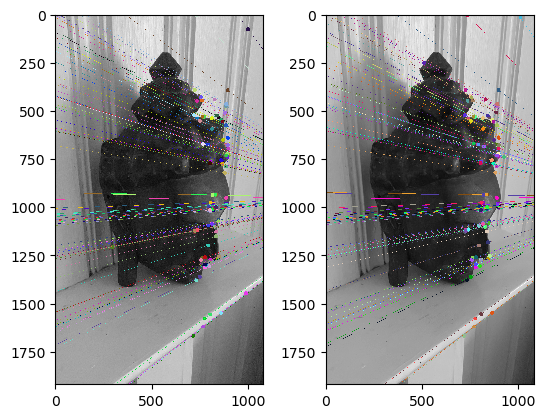

In [118]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    %matplotlib inline
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        # print(tuple(pt1))
        img1 = cv2.circle(img1,tuple((int(pt1[0]),int(pt1[1]))),10,color,-1)
        img2 = cv2.circle(img2,tuple((int(pt2[0]),int(pt2[1]))),10,color,-1)
    return img1,img2



lines1 = cv2.computeCorrespondEpilines(matches1_ransac_test.reshape(-1,1,2), 2,F_ransac)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(images_list[0],images_list[1],lines1,matches1_ransac_test,matches2_ransac_test)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(matches2_ransac_test.reshape(-1,1,2), 1,F_ransac)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(images_list[1], images_list[0],lines2,matches2_ransac_test,matches1_ransac_test)



# lines1 = cv2.computeCorrespondEpilines(matches1.reshape(-1,1,2), 2,F_ransac)
# lines1 = lines1.reshape(-1,3)
# img5,img6 = drawlines(images_list[6],images_list[7],lines1,matches1,matches2)
# # Find epilines corresponding to points in left image (first image) and
# # drawing its lines on right image
# lines2 = cv2.computeCorrespondEpilines(matches2.reshape(-1,1,2), 1,F_ransac)
# lines2 = lines2.reshape(-1,3)
# img3,img4 = drawlines(images_list[7],images_list[6],lines2,matches2,matches1)




plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

In [119]:
def compute_essential_mat(matches1, matches2, K, use_gt = True):
    
    if use_gt:
        E, mask = cv2.findEssentialMat(matches1, matches2, K, cv2.RANSAC, 0.999, 1)
        mask_indices = np.argwhere(mask == 1)
        print(len(mask_indices))
        matches1_ransac = matches1[mask_indices[:,0]]
        matches2_ransac = matches2[mask_indices[:,0]]

    else:
        F_ransac, matches1_ransac, matches2_ransac = compute_F_ransac(matches1, matches2,threshold = .005)
        E = np.matmul(K.T,np.matmul(F_ransac, K))
    return E, matches1_ransac, matches2_ransac

K = np.array([[1600,0,1080/2],[0,1600,1920/2],[0,0,1]], dtype = np.float32)
E_first_pair, matches1_ransac_test, matches2_ransac_test = compute_essential_mat(pts_1_test, pts_2_test, K)


232


In [120]:
def custom_recover_pose(E, matches1_ransac, matches2_ransac):

    R1, R2, T = cv2.decomposeEssentialMat(E)
    P_first_image = np.hstack((np.eye(3), np.zeros((3,1))))
    P_s = []

    dictionary = {0:tuple((R1, T)),1: tuple((R1, -T)),2: tuple((R2, T)), 3: tuple((R2, -T))}
    number = []
    for i in range(4):

        R, T = dictionary[i]
        P = np.matmul(R, np.hstack((np.eye(3), -T)))
        points_3d = cv2.triangulatePoints(P_first_image, P, matches1_ransac.T, matches2_ransac.T)
        points_3d = points_3d/points_3d[3]
        test_1 = np.argwhere(points_3d[2] > 0)
        # print(test_1.shape[0])
        checker = np.matmul(R,points_3d[0:3]-T) ################
        test_2 = np.argwhere(checker[2]>0)
        # print(test_1.shape[0],test_2.shape[0])
        minimum = test_1.shape[0]+test_2.shape[0]
        # print(minimum)
        number.append(minimum)
        P_s.append(P)

    correct = np.argmax(number)

    if np.linalg.det(dictionary[correct][0]) >0:
        R_final = dictionary[correct][0]
        T_final = -dictionary[correct][1]
        print("true")
    else:
        R_final = -dictionary[correct][0]
        T_final = dictionary[correct][1]

    
    return correct, P_s[correct], R_final, T_final

In [121]:
def compute_pose_and_points(E, matches1, matches2):#, K, use_gt = True):

    # inlier_count, R, T, mask = cv2.recoverPose(E, matches1, matches2, K)
    inlier_count, R, T, mask = cv2.recoverPose(E, matches1, matches2) #, K)
    # print(inlier_count)
    mask_indices = np.argwhere(mask >0)
    #print(len(mask_indices), inlier_count, matches1.shape)
    matches1_chiral = matches1[mask_indices[:,0]]
    matches2_chiral = matches2[mask_indices[:,0]]

    # correct, P_matrix, R_n, T_n = custom_recover_pose(E, matches1, matches2)
    # print(inlier_count, R-R_n, T-T_n)
    return matches1_chiral, matches2_chiral, R, T

def make_pose(R, T):
    between_pose = np.eye(4)
    between_pose[:3,:3] = R
    if T.ndim == 1:
        between_pose[:3,3] = T
    else:
        between_pose[:3,3] = T.ravel()

    return between_pose

def compute_projection(pose, K):
    
    return np.matmul(K ,np.linalg.inv(pose)[:3, :])


compute_pose_and_points(E_first_pair, matches1_ransac_test, matches2_ransac_test)

(array([[ 491.10397339, 1809.71032715],
        [ 571.85113525,  284.51309204],
        [ 737.06854248,  450.50735474],
        [ 816.35760498,  595.72167969],
        [ 885.56317139,  789.30596924],
        [ 887.3659668 ,  791.28277588],
        [ 763.68035889,  449.27383423],
        [ 725.10797119,  394.60562134],
        [ 688.96295166,  352.74816895],
        [ 795.5513916 , 1200.41674805],
        [ 873.47351074,  653.50024414],
        [ 633.46655273,  223.82539368],
        [ 639.14794922,  252.82209778],
        [ 821.45361328, 1007.57928467],
        [ 738.84326172,  542.27514648],
        [ 722.55822754,  523.58837891],
        [ 837.43688965, 1005.90087891],
        [ 446.36114502,  379.22683716],
        [ 715.12316895,  399.11520386],
        [ 477.88562012,  391.84985352],
        [ 862.32220459,  758.23876953],
        [ 508.52496338,  332.65200806],
        [ 666.89984131,  344.19372559],
        [ 749.39385986,  426.08273315],
        [ 848.54089355,  535.19030762],


In [122]:
class Point3D():
    def __init__(self, point_3d, frame, match):
        self.frames = []
        self.matches = []
        self.point = point_3d
        self.frames.append(frame)
        self.matches.append(match)
        # self.match2 = match2
    def add(self, frame, match):
        self.frames.append(frame)
        self.matches.append(match)

p = Point3D(np.array([1,2,3]),1,np.array([2,3]))
print(p.frames, type(p.matches))
p = np.empty(140,dtype=Point3D)

def triangulate_points(matches1, matches2, P1, P2):

    points_3d_homo = cv2.triangulatePoints(P1, P2, matches1.T, matches2.T)
    points_3d_homo = points_3d_homo[:3,:]/points_3d_homo[3,:]
    points_3d = points_3d_homo

    # check_indices = np.argwhere(points_3d[2]>0).reshape(-1)
    # print("Check Indices")
    # print(check_indices.shape)
    # print(points_3d[2], check_indices.shape)
    
    return points_3d.T, matches1, matches2


[1] <class 'list'>


In [123]:
K = np.array([[1600,0,1080/2],[0,1600,1920/2],[0,0,1]], dtype = np.float32) ##Never touch

def compute_odometry_points(keypoints_list, desc_list, K):

    camera_poses = []
    camera_poses.append(np.eye(4))
    i = 0
    Point3d_cloud = []
    for i in range(len(keypoints_list)-1):

        matches_1, matches_2 = compute_matches(keypoints_list[i], keypoints_list[i+1], desc_list[i], desc_list[i+1])
        E_pair, matches1_ransac, matches2_ransac = compute_essential_mat(matches_1, matches_2, K)

        if i == 0:

            matches1_chiral, matches2_chiral, R, T = compute_pose_and_points(E_pair, matches1_ransac, matches2_ransac)
            camera_pose = make_pose(R,T)
            world_camera_pose = np.linalg.inv(camera_pose)
            camera_poses.append(world_camera_pose)
            
            P1 = compute_projection(np.eye(4), K)
            P2 = compute_projection(world_camera_pose, K)

            points_3d, matches1_3check, matches2_3check = triangulate_points(matches1_chiral, matches2_chiral, P1, P2)
            # print(points_3d.shape, matches1_3check.shape, matches2_3check.shape)
            prev_matches = matches2_3check

            for p in range(points_3d.shape[0]):
                point_obj = Point3D(points_3d[p], i, matches1_3check[p])
                point_obj.add(i+1, matches2_3check[p])
                Point3d_cloud.append(point_obj)
            
        else:
            # break

            point_3d_pnp = []
            match1_pnp = []
            match2_pnp = []
            # print(prev_matches)
            # print(matches1_ransac)

                # if m==3:
                #     break
            for ps, point in enumerate(Point3d_cloud):
                try:
                    value = point.frames.index(i)

                    for m, match1_ransac in enumerate(matches1_ransac):

                        # print(point.matches[value].shape)
                        if np.array_equal(point.matches[value],match1_ransac):
                            # print("INI")
                            point_3d_pnp.append(point.point)
                            match1_pnp.append(matches1_ransac[m])
                            match2_pnp.append(matches2_ransac[m])


                except ValueError:
                    continue
            
            print(len(match1_pnp),len(match2_pnp),len(point_3d_pnp))
            points_3d_pnp = np.array(point_3d_pnp)
            matches1_pnp = np.array(match1_pnp)
            matches2_pnp = np.array(match2_pnp)
            _, rvec, tvec, inlier_numbers = cv2.solvePnPRansac(points_3d_pnp, matches2_pnp, K, None)
            R, _ = cv2.Rodrigues(rvec)
            camera_pose = make_pose(R, tvec)
            camera_poses.append(np.linalg.inv(camera_pose))
            P1 = compute_projection(camera_poses[i], K)
            P2 = compute_projection(camera_poses[i+1], K)

            new_points_3d, matches1_3check, matches2_3check = triangulate_points(matches1_ransac, matches2_ransac, P1, P2)
            # for push_lap in range(len(matches1_3check)):
            #     print(matches1_3check[push_lap], matches2_3check[push_lap])

            for ma in range(len(matches1_3check)):
                exist = False
                for point in Point3d_cloud:
                    try:
                        val = point.frames.index(i)
                        if np.array_equal(point.matches[val],matches1_3check[ma]):
                            if i+1 in point.frames:
                                continue
                            else:
                                point.add(i+1, matches2_3check[ma])
                            exist = True
                            break
                    except ValueError:
                        continue
                
                if exist == False:
                    point_new = Point3D(new_points_3d[ma], i, matches1_3check[ma])
                    point_new.add(i+1, matches2_3check[ma])
                    Point3d_cloud.append(point_new)

        # if i ==1:
        #     break
        # print(len(Point3d_cloud))

    return camera_poses, Point3d_cloud     

camera_poses, Point3d_list = compute_odometry_points(keypoints_list, desc_list, K)
    # if i ==2:
    #     break


232
153
86 86 86
153
79 79 79
44
19 19 19
54
16 16 16
71
18 18 18
76
23 23 23
42
10 10 10
57
14 14 14
62
25 25 25
62
23 23 23
68
24 24 24
42
12 12 12
45
11 11 11
75
17 17 17
94
33 33 33
93
39 39 39
100
41 41 41
78
32 32 32
89
29 29 29
122
41 41 41
71
36 36 36
74
29 29 29


In [124]:
for point in Point3d_list:
    print(point.point, point.frames, point.matches)

print(len(Point3d_list))
print(len(camera_poses))

[ -8.5496079  148.38732615 279.51355372] [0, 1, 2, 3] [array([ 491.10397339, 1809.71032715]), array([ 489.31646729, 1809.19104004]), array([ 489.82531738, 1822.06298828]), array([ 509.15420532, 1863.77087402])]
[   85.87226564 -1820.4424793   4312.00297295] [0, 1, 2, 3] [array([571.85113525, 284.51309204]), array([570.46887207, 284.150177  ]), array([578.44104004, 282.55743408]), array([618.14227295, 279.12805176])]
[  663.47829491 -1715.19977342  5386.37575972] [0, 1, 2] [array([737.06854248, 450.50735474]), array([735.76416016, 450.22073364]), array([745.19232178, 450.81365967])]
[  944.26940234 -1244.55313413  5466.40636586] [0, 1, 2] [array([816.35760498, 595.72167969]), array([815.12091064, 595.44177246]), array([826.14227295, 596.30761719])]
[17895.42492967 -8825.55517776 82755.1422303 ] [0, 1] [array([885.56317139, 789.30596924]), array([885.16497803, 789.2824707 ])]
[1099.46736579 -533.39585436 5059.68407928] [0, 1] [array([887.3659668 , 791.28277588]), array([886.75811768, 791

# Plot Functions for interactive view and top view

In [125]:
def PlotCamera(R,t,ax,scale=.15,depth=.15,faceColor='grey'):
    C = -t #camera center (in world coordinate system)

    #Generating camera coordinate axes
    axes = np.zeros((3,6))
    axes[0,1], axes[1,3],axes[2,5] = 1,1,1
    
    #Transforming to world coordinate system 
    axes = R.T.dot(axes)+C[:,np.newaxis]

    #Plotting axes
    ax.plot3D(xs=axes[0,:2],ys=axes[1,:2],zs=axes[2,:2],c='r')
    ax.plot3D(xs=axes[0,2:4],ys=axes[1,2:4],zs=axes[2,2:4],c='g')
    ax.plot3D(xs=axes[0,4:],ys=axes[1,4:],zs=axes[2,4:],c='b')

    #generating 5 corners of camera polygon 
    pt1 = np.array([[0,0,0]]).T #camera centre
    pt2 = np.array([[scale,depth, scale]]).T #upper right 
    pt3 = np.array([[scale,depth, -scale]]).T #lower right 
    pt4 = np.array([[-scale,depth, scale]]).T #upper left
    pt5 = np.array([[-scale,depth, -scale]]).T #lower left
    pts = np.concatenate((pt1,pt2,pt3,pt4,pt5),axis=-1)
    
    #Transforming to world-coordinate system
    pts = R.T.dot(pts)+C[:,np.newaxis]
    ax.scatter3D(xs=pts[0,:],ys=pts[1,:],zs=pts[2,:],c='k')
    
    #Generating a list of vertices to be connected in polygon
    verts = [[pts[:,0],pts[:,1],pts[:,2]], [pts[:,0],pts[:,2],pts[:,-1]],
            [pts[:,0],pts[:,-1],pts[:,-2]],[pts[:,0],pts[:,-2],pts[:,1]]]
    
    #Generating a polygon now..
    ax.add_collection3d(Poly3DCollection(verts, facecolors=faceColor,
                                         linewidths=1, edgecolors='k', alpha=.25))
    
def plot_3d_pose(cumilative_poses):
    %matplotlib qt
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')

    for pose in cumilative_poses:

        PlotCamera(pose[:3,:3],pose[:3,3],ax)

def plot_3d_points(global_points):
    %matplotlib qt
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')

    points_3d = global_points.T
    points_3d = points_3d/points_3d[3]
    ptsv2 = points_3d.T
    ax.scatter(ptsv2[:,0], ptsv2[:,1], ptsv2[:,2])


plot_3d_pose(camera_poses)

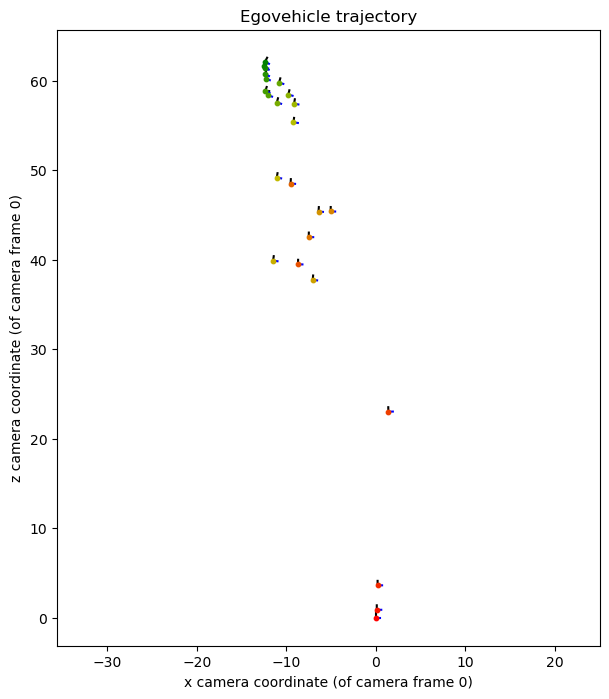

In [126]:
def plot_poses(poses_wTi: list, figsize=(7, 8)) -> None:
    """
    Poses are wTi (in world frame, which is defined as 0th camera frame)
    """
    axis_length = 0.5

    num_poses = len(poses_wTi)
    colors_arr = np.array([[color_obj.rgb] for color_obj in Color("red").range_to(Color("green"), num_poses)]).squeeze()

    _, ax = plt.subplots(figsize=figsize)

    for i, wTi in enumerate(poses_wTi):
        wti = wTi[:3, 3]

        # assume ground plane is xz plane in camera coordinate frame
        # 3d points in +x and +z axis directions, in homogeneous coordinates
        posx = wTi @ np.array([axis_length, 0, 0, 1]).reshape(4, 1)
        posz = wTi @ np.array([0, 0, axis_length, 1]).reshape(4, 1)
        
        # print([wti[0], posz[0][0]])
        # print([wti[2], posx[2][0]])
        if i==30:
            break
        ax.plot([wti[0], posx[0][0]], [wti[2], posx[2][0]], "b", zorder=1)
        ax.plot([wti[0], posz[0][0]], [wti[2], posz[2][0]], "k", zorder=1)

        ax.scatter(wti[0], wti[2], 40, marker=".", color=colors_arr[i], zorder=2)

    plt.axis("equal")
    plt.title("Egovehicle trajectory")
    plt.xlabel("x camera coordinate (of camera frame 0)")
    plt.ylabel("z camera coordinate (of camera frame 0)")
%matplotlib inline
plot_poses(camera_poses)

In [127]:
L = gtsam.symbol_shorthand.L
X = gtsam.symbol_shorthand.X
cam_K = gtsam.Cal3_S2(K[0,0], K[1,1], 0, K[0,2], K[1,2])

MEASURE_NOISE = gtsam.noiseModel.Isotropic.Sigma(2, 10)
POSE_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([3, 3, 3, 1, 1, 1]))
POINT_NOISE = gtsam.noiseModel.Isotropic.Sigma(3, 1)

graph = gtsam.NonlinearFactorGraph() #initializing graph

initial = gtsam.Values()

prior_initial = camera_poses[0]
K_key = 20000
initial.insert(K_key, cam_K)
factor = gtsam.PriorFactorPose3(X(0),gtsam.Pose3(prior_initial), POSE_NOISE)
graph.push_back(factor)
# factor = gtsam.PriorFactorPose3(X(10),gtsam.Pose3(camera_poses[10]), POSE_NOISE)
# graph.push_back(factor)
factor = gtsam.PriorFactorPoint3(L(0), gtsam.Point3(Point3d_list[0].point), POINT_NOISE)
# graph.push_back(factor)
# factor = gtsam.PriorFactorPoint3(L(8), gtsam.Point3(Point3d_list[8].point), POINT_NOISE)
# graph.push_back(factor)
# factor = gtsam.PriorFactorPoint3(L(11), gtsam.Point3(Point3d_list[11].point), POINT_NOISE)
# graph.push_back(factor)


for ps, point in enumerate(Point3d_list):
    initial.insert(L(ps), gtsam.Point3(point.point)) 
    for fs, cam in enumerate(point.frames):
        factor = gtsam.GenericProjectionFactorCal3_S2(point.matches[fs],MEASURE_NOISE, X(fs), L(ps), cam_K)
        graph.push_back(factor)

# for ps, point in enumerate(Point3d_list):
#     initial.insert(L(ps), gtsam.Point3(point.point)) 

for i, cam in enumerate(camera_poses):
    initial.insert(X(i),gtsam.Pose3(cam))

print(initial)



Values with 1324 values:
Value 20000: (gtsam::Cal3_S2)
[
	1600, 0, 540;
	0, 1600, 960;
	0, 0, 1
]

Value l0: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-8.54961;
	148.387;
	279.514
]

Value l1: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	85.8723;
	-1820.44;
	4312
]

Value l2: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	663.478;
	-1715.2;
	5386.38
]

Value l3: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	944.269;
	-1244.55;
	5466.41
]

Value l4: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	17895.4;
	-8825.56;
	82755.1
]

Value l5: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	1099.47;
	-533.396;
	5059.68
]

Value l6: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	164.202;
	-375.169;
	1175.32
]

Value l7: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-1035.65;
	3153.4;
	-8923.6
]

Value l8: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-4013.81;
	16319.7;
	-42998.3
]

Value l9: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	508.385;
	477.922;
	3180.4
]

Value l10: (Eigen::Matrix<double, -1, 1, 0, -1,

In [128]:
params = gtsam.DoglegParams()
params.setVerbosity('TERMINATION')
optimizer = gtsam.DoglegOptimizer(graph, initial, params)
print('Optimizing:')
result = optimizer.optimize()
result.print('Final results:\n')
print('initial error = {}'.format(graph.error(initial)))
print('final error = {}'.format(graph.error(result)))

Optimizing:


RuntimeError: 
Indeterminant linear system detected while working near variable
7782220156096217089 (Symbol: l1).

Thrown when a linear system is ill-posed.  The most common cause for this
error is having underconstrained variables.  Mathematically, the system is
underdetermined.  See the GTSAM Doxygen documentation at
http://borg.cc.gatech.edu/ on gtsam::IndeterminantLinearSystemException for
more information.

In [86]:
params = gtsam.LevenbergMarquardtParams()
params.setVerbosityLM("SUMMARY")
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)
result = optimizer.optimize()

Initial error: 3.57803e+07, values: 1324


RuntimeError: An inference algorithm was called with inconsistent arguments.  The
factor graph, ordering, or variable index were inconsistent with each
other, or a full elimination routine was called with an ordering that
does not include all of the variables.

In [ ]:
def plot_factor_graph( graph, estimates, X, L, title, plot_cov=True):
    print(estimates)
    for i in range(estimates.size()):
        gtsam.utils.plot.plot_pose3(X(i), estimates.atPose3(i))
        
    # Plot the edges
    for i in range(1, graph.size()):
        key1, key2 = graph.at(i).keys()
        pose1 = estimates.atPose2(key1)
        pose2 = estimates.atPose2(key2)
        plt.plot([pose1.x(), pose2.x()], [pose1.y(), pose2.y()], color='blue')
    
    plt.title(title)
    plt.show()
